# 2-Photon Microscopy of Larval Zebrafish 

## Step 1: Load and preparing data.

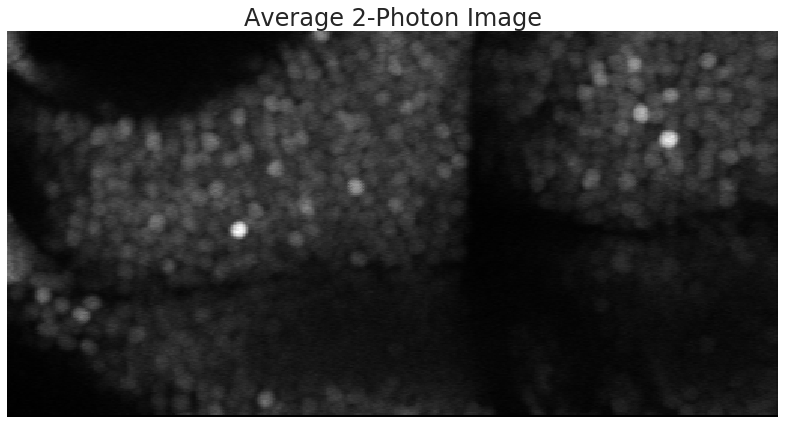

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.external import tifffile
sns.set_style('white')
sns.set_context('notebook', font_scale=2)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
f = 'fish008.tif'

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load data.
tiff = tifffile.imread('raw/%s' %f)

## Assemble into red light and green fluorescence.
green, red = tiff[::2], tiff[1::2]

## Normalize values.
def normalize(arr): 
    return (arr - arr.min()) / (arr.max() - arr.min())

green = normalize(green)
red = normalize(red)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

fig, ax = plt.subplots(1,1,figsize=(12,6))
sns.heatmap(green.sum(axis=0), cmap='binary_r', square=True, cbar=False, ax=ax, )
ax.set(xticks=[], yticks=[], title='Average 2-Photon Image');
plt.tight_layout()

## Step 2a: Interactive Visualization
This section will only work in the Jupyter-Notebook (sorry GitHub lurkers).

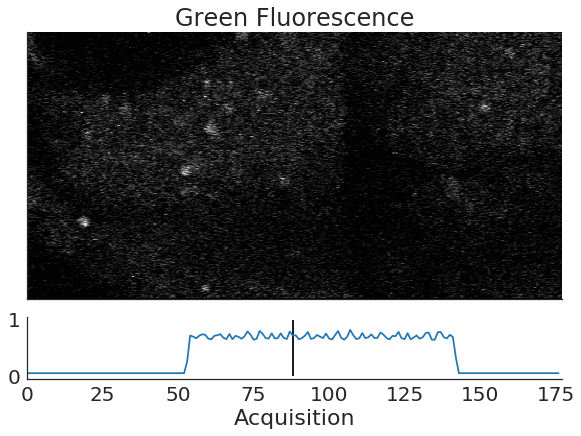

In [2]:
from ipywidgets import interact

def visualize_ts(t):
    
    fig = plt.figure(figsize=(8,6))
    rs = 8
    
    ax = plt.subplot2grid((10,1),(0,0),rowspan=rs)
    sns.heatmap(green[t], cmap='binary_r', square=True, cbar=False, ax=ax)
    ax.set(xticks=[], yticks=[], title='Green Fluorescence');
    
    ax = plt.subplot2grid((10,1),(rs,0),rowspan=10-rs)
    ax.plot(np.apply_over_axes(np.mean, red, [1,2]).squeeze())
    ax.vlines(t, 0, 1)
    ax.set(xlim=(0, green.shape[0]), xlabel='Acquisition')
    
    sns.despine()
    plt.tight_layout()
    
interact(visualize_ts, t=(0,green.shape[0]));

## Step 2b: Write images for GIF
After writing, GIF made with [Giphy](https://giphy.com/create/gifmaker).

In [ ]:
from ipywidgets import interact

for t in range(green.shape[0]):
    
    fig = plt.figure(figsize=(8,6))
    rs = 8
    
    ax = plt.subplot2grid((10,1),(0,0),rowspan=rs)
    sns.heatmap(green[t], cmap='binary_r', square=True, cbar=False, ax=ax)
    ax.set(xticks=[], yticks=[], title='Green Fluorescence');
    
    ax = plt.subplot2grid((10,1),(rs,0),rowspan=10-rs)
    ax.plot(np.apply_over_axes(np.mean, red, [1,2]).squeeze())
    ax.vlines(t, 0, 1)
    ax.set(xlim=(0, green.shape[0]), xlabel='Acquisition')
    
    sns.despine()
    plt.tight_layout()
    plt.savefig('gif/img%0.3d.png' %t)
    plt.close()

## Step 3: Identifying Neurons
### Step 3a: Zoom in

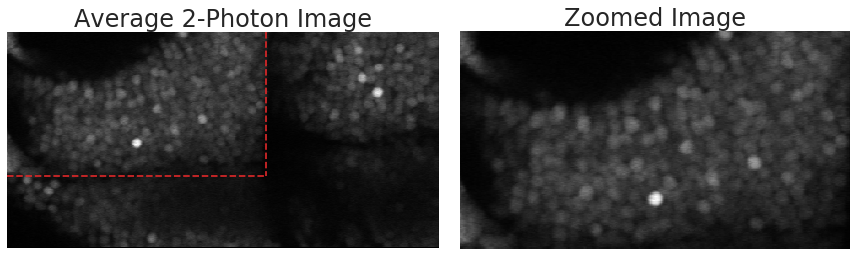

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Cropping parameters.
x_frac = 0.60
y_frac = 0.67

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Cropping and thresholding.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define boundaries for cropping
n_acq, n_row, n_col = green.shape
m = int(n_col * x_frac)
n = int(n_row * y_frac) 

## Crop image.
zgreen = green[:,:n,:m]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize convas.
fig, axes = plt.subplots(1,2,figsize=(12,4))

## Plot original.
sns.heatmap(green.sum(axis=0), cmap='binary_r', square=True, cbar=False, ax=axes[0])
axes[0].set(xticks=[], yticks=[], title='Average 2-Photon Image');

## Demarcate boundaries.
axes[0].hlines(n, 0, m, linestyle='--', color='#d62728')
axes[0].vlines(m, 0, n, linestyle='--', color='#d62728')

## Plot zoomed image.
sns.heatmap(zgreen.sum(axis=0), cmap='binary_r', square=True, cbar=False, ax=axes[1])
axes[1].set(xticks=[], yticks=[], title='Zoomed Image');

plt.subplots_adjust(left=0, right=1, wspace=0)

### Step 3b: Regression

In [4]:
red_mean = np.apply_over_axes(np.mean, red, [1,2]).squeeze()
indices, = np.where(red_mean > 0.05)

total_time = 30 # seconds
sfreq = indices.shape[0] / total_time

durations = [0, 3, 5, 5, 5, 5, 5, 2]
events = (indices.min() + np.cumsum(durations) * sfreq).astype(int)

In [5]:
basis = np.sin(0.5 * np.pi * np.linspace(0,2,15))

X = np.zeros((zgreen.shape[0], 3))
X[:,0] = 1

for i in np.arange(0, events.size-1):

    if not i:
        X[events[i]:events[i+1],i%2+1] = basis[-(events[i+1]-events[i]):]
    else:
        X[events[i]:events[i+1],i%2+1] = basis[:(events[i+1]-events[i])]

In [6]:
n_acq, n_row, n_col = zgreen.shape
y = zgreen.reshape(n_acq, n_row*n_col)
b, _, _, _ = np.linalg.lstsq(X, y)
b = b.reshape(3, n_row, n_col)

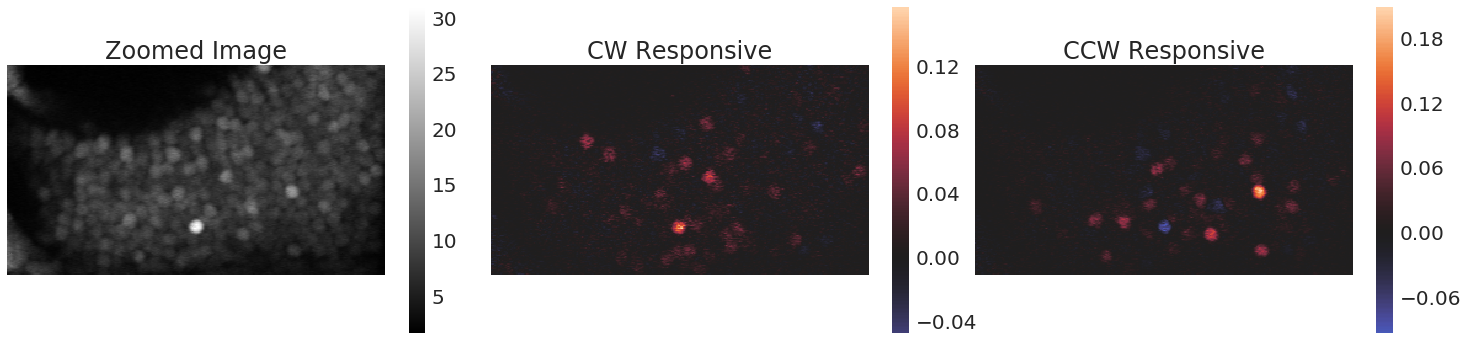

In [7]:
fig, axes = plt.subplots(1,3,figsize=(20,6))

## Plot zoomed image.
sns.heatmap(zgreen.sum(axis=0), cmap='binary_r', square=True, cbar=True, ax=axes[0])
axes[0].set(xticks=[], yticks=[], title='Zoomed Image');

## Plot clockwise-responsive.
sns.heatmap(b[1], square=True, center=0, ax=axes[1])
axes[1].set(xticks=[], yticks=[], title='CW Responsive');

## Plot counterclockwise-responsive.
sns.heatmap(b[2], square=True, center=0, ax=axes[2])
axes[2].set(xticks=[], yticks=[], title='CCW Responsive');

plt.subplots_adjust(left=0, right=1, wspace=0.025)